### refer code 
https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/contrib/legacy_seq2seq/python/ops/seq2seq.py

https://ratsgo.github.io/natural%20language%20processing/2017/03/12/s2s/

http://goodtogreate.tistory.com/entry/%ED%95%99%EC%8A%B5-%EB%AA%A8%EB%8D%B8%EC%9D%98-%EC%9E%AC%EC%82%AC%EC%9A%A9-Transfer-Learning?category=620143

### import packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4" #4번 DEVICES만 사용하여 다른 메모리를 낭비를 방지
import time

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

#costomized seq2seq cell
import copy
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import variable_scope

In [3]:
#=======================================Hyperparameter 
learning_rate = 0.001
total_epoch = 1000
batch_size = 100 
dropout = 0.5
hidden_size = 200
index = 0

feed_train = {}
feed_val = {}
outputs = []
targets = []
DATAS = []
data_size = 50

#훈련에 사용할 데이터 이름을 배열로 저장한다. 
traindatasets = ['Plane', 'Gun_Point', 'ArrowHead', 'WordsSynonyms', 'ToeSegmentation1', 'FISH', 'ShapeletSim', 'ShapesAll', 'SonyAIBORobotSurfaceII',
             'Lighting7', 'ToeSegmentation2', 'DiatomSizeReduction', 'Ham', 'SonyAIBORobotSurface', 'TwoLeadECG', 'FacesUCR']

In [4]:
def customized_rnn_seq2seq(encoder_inputs,
                          decoder_inputs,
                          cell,
                          dtype=dtypes.float32,
                          scope=None):
    
    with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
        enc_cell = copy.deepcopy(cell)
        encoder_outputs, enc_state = tf.contrib.rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
    return customized_rnn_decoder(encoder_outputs, decoder_inputs, enc_state, cell)

def customized_rnn_decoder(encoder_outputs,
                decoder_inputs,
                initial_state,
                cell,
                loop_function=None,
                scope=None):
    
    with variable_scope.variable_scope(scope or "rnn_decoder"):
        state = initial_state
        outputs = []
        prev = None
        for i, inp in enumerate(decoder_inputs):
            if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                    inp = loop_function(prev, i)
            if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
            output, state = cell(inp, state)
            outputs.append(output)
            if loop_function is not None:
                prev = output
    return encoder_outputs, outputs, state

def data_maker(dataset):

    #train 숫자가 너무 작아서 concatenate이후 train_test_split를 이용해 다시 나눈다.
    datadir = '/home/sohee/UCR_TS_Archive_2015' + '/' + dataset + '/' + dataset
    data_train = np.loadtxt(datadir+'_TRAIN', delimiter=',')
    data_test = np.loadtxt(datadir+'_TEST', delimiter=',')
    DATA = np.concatenate((data_train,data_test),axis=0)
    
    #특정 데이터의 y lable이 1부터 시작해 range error 발생.첫 인덱스가 1이면 1을 빼서 0으로 만듬
    X_data = DATA[:,1:]
    y_data = DATA[:,[0]]
    y_first_index = int(np.unique(y_data)[0])
    if int(y_first_index) == 1:
        y_data = DATA[:,[0]]-1
    DATA = np.concatenate((y_data, X_data), axis=1)
    
    #50행마다 잘라서 DATAS 배열에 저정
    iter = DATA.shape[0]//data_size
    for i in range(iter):
        CUT_DATA = DATA[50*i:50*(i+1),:]
        DATAS.append(CUT_DATA)
    
def seq2seq_maker(index, DATA):

    X_data = DATA[:,1:]
    y_data = DATA[:,0]
    
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=1)
    
    encoder_input = tf.placeholder(tf.float32, [None, X_train.shape[1]]) 
    decoder_input = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    target = tf.placeholder(tf.int64, [None])

    targets.append(target)
    
    with tf.variable_scope("rnn_"+str(index)):
        cell = tf.contrib.rnn.GRUCell(num_units=hidden_size)
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5)
        #output, states = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq([encoder_input], [decoder_input], cell)
        en_outputs, de_outputs, state = customized_rnn_seq2seq([encoder_input], [decoder_input], cell)
        #print("encoder_outputs", encoder_outputs)
        #print("decoder_outputs", decoder_outputs)
        de_outputs = tf.reshape(de_outputs, [-1, hidden_size]) #3D -> 2D
        outputs.append(de_outputs)
    
    feed_train[encoder_input] = X_train
    feed_train[decoder_input] = X_train
    feed_train[target] = y_train
    
    feed_val[encoder_input] = X_val
    feed_val[decoder_input] = X_val
    feed_val[target] = y_val

In [5]:
import copy
#data_maker('Plane')        
for dataset in traindatasets:
    data_maker(dataset)    
    
for index, DATA in enumerate(DATAS):
    seq2seq_maker(index, DATA)

In [6]:
W = tf.Variable(tf.random_normal([hidden_size, 100]), name="W") 
b = tf.Variable(tf.random_normal([100]), name="b") #최대 클래수의 갯수인 60보다는 커야 range 에러 안생김
print("W", W)
print("b", b)
logits = [tf.matmul(output, W) + b for output in outputs]

with tf.variable_scope("cost"):
    loss = []
    for logit, target in zip(logits, targets):
        loss.append(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=target))
    #cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    cost= tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
    
#with tf.variable_scope("eval"):
#    prediction = tf.argmax(tf.nn.softmax(logits), 1) 
#    correct_prediction = tf.equal(prediction, targets)#one-hot을 안쓰면 target에는 argmax할 필요없음
#    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    

W <tf.Variable 'W:0' shape=(200, 100) dtype=float32_ref>
b <tf.Variable 'b:0' shape=(100,) dtype=float32_ref>


[[-1.5448986  -1.1371617   0.0773662  ...  0.82137316  0.51545596
  -0.9244549 ]
 [ 1.0209038   1.6455933  -0.48959976 ... -0.20162494 -0.23283646
   1.332634  ]
 [-1.5625007   1.071932   -0.03201443 ...  2.4305334   1.0227883
  -0.24309865]
 ...
 [ 1.2689362  -1.8014126   0.01996725 ...  0.5329083   2.0826888
   1.5131649 ]
 [-2.0054545   0.88894826 -1.1623902  ... -0.74638873 -0.32370254
   0.74595386]
 [-0.90793306 -1.8431424  -0.7487478  ... -0.44549438  2.5503893
  -0.58375955]]
[ 0.7073748  -0.24955054  0.9855334  -0.2175885  -0.6083187   0.01843228
  1.9727991  -1.3733896  -0.24092354  1.3622707  -0.6743891   1.6965421
 -1.332943   -0.45975342  0.31077522 -0.45731163 -0.73663557 -0.5727888
  0.3063251   0.5089056  -1.5382974   0.95531565  0.47342455 -0.9162985
  0.54488367 -1.646736    0.25445363 -1.2127312  -0.23559396  0.32538667
  0.04274403  0.7943055   0.6772164  -1.0785744   1.2319291   1.3345857
  0.654709   -0.50423646 -1.1251199   0.98265064  2.30531     1.115077
  0.01

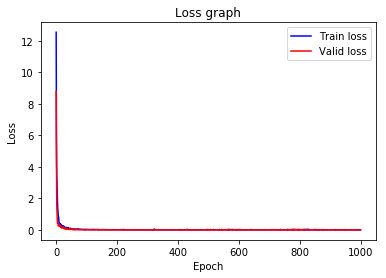

[[-1.5188171  -1.1830055   0.07445481 ...  0.8496041   0.55575186
  -0.90386117]
 [ 1.0398973   1.622519   -0.4554843  ... -0.17858984 -0.23790553
   1.2882482 ]
 [-1.5582815   1.0909929  -0.0664992  ...  2.3836384   1.0292011
  -0.24032348]
 ...
 [ 1.2444952  -1.7752839   0.00443563 ...  0.5518908   2.0320942
   1.4881381 ]
 [-2.0207126   0.912037   -1.1536913  ... -0.70897245 -0.34747845
   0.74041975]
 [-0.95453584 -1.8031652  -0.7909881  ... -0.4206593   2.5216742
  -0.5692561 ]]
[ 7.2758472e-01 -2.1775395e-01  1.0312799e+00 -1.8643221e-01
 -5.7178456e-01  5.0794221e-02  1.9882026e+00 -1.3332148e+00
 -2.3002884e-01  1.4005704e+00 -6.4365965e-01  1.7487326e+00
 -1.3056825e+00 -4.2848760e-01  3.1471255e-01 -4.3307689e-01
 -7.0473325e-01 -5.2200639e-01  3.6439505e-01  5.4100829e-01
 -1.4878283e+00  1.0215020e+00  5.0283778e-01 -8.8004667e-01
  5.1647073e-01 -1.6794685e+00  2.3090263e-01 -1.2460880e+00
 -2.6093614e-01  2.8097937e-01 -1.1087315e-03  7.5567442e-01
  6.4506847e-01 -1.1133

In [7]:
saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    print("============================sess init")
    start_time = time.time()
    train_losses = []
    valid_losses = []
    for epoch in range(total_epoch):
        _, tr_loss = sess.run([optimizer, cost], feed_dict = feed_train)
        _, va_loss = sess.run([optimizer, cost], feed_dict = feed_val)
        train_losses += [tr_loss]
        valid_losses += [va_loss]
        if epoch % 100 == 0:  
            print("Epoch {}/{} took {:.3f}s".format(epoch + 1, total_epoch,time.time() - start_time))
            print("  Train      loss : %.6f"%(train_losses[epoch]))
            print("  Validation loss : %.6f"%(valid_losses[epoch]))
    print("It took", time.time() - start_time, "seconds to train for", total_epoch, "epochs.")        
    print("============================ training end")
    
    #loss  그래프를 확인한다. 
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(valid_losses, '-r', label='Valid loss')
    plt.legend(loc=0)
    plt.title('Loss graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    #print('Accuracy:', sess.run(accuracy_op, feed_dict=feed_dict))
    
    #pred = sess.run(prediction, feed_dict=feed_dict)
    #for p, i in zip(pred, y_test.flatten()):
    #    print("[{}] Prediction: {} True Y: {}".format(p == int(i), p, int(i)))
        
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    save_path = saver.save(sess, "./180123.ckpt")
    print("model saved!")

In [10]:
tf.reset_default_graph()
saver = tf.train.import_meta_graph("./180123.ckpt.meta")

In [11]:
learning_rate = 0.001
total_epoch = 1000
batch_size = 100 
dropout = 0.5
hidden_size = 200
index = 0

dataset = 'ChlorineConcentration'
datadir = '/home/sohee/UCR_TS_Archive_2015' + '/' + dataset + '/' + dataset
data_train = np.loadtxt(datadir+'_TRAIN', delimiter=',')
data_test = np.loadtxt(datadir+'_TEST', delimiter=',')

#train 숫자가 너무 작아서 concatenate이후 train_test_split를 이용해 다시 나눈다.
DATA = np.concatenate((data_train,data_test),axis=0)
X_data_n = DATA[:,1:]
y_data_n = DATA[:,0]

#특정 데이터의 y lable이 1부터 시작해 range error 발생.첫 인덱스가 1이면 1을 빼서 0으로 만듬
y_first_index = int(np.unique(y_data_n)[0])
if int(y_first_index) == 1:
    y_data_n = DATA[:,0]-1

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_data_n, y_data_n, test_size=0.2, random_state=1)
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_train_n, y_train_n, test_size=0.2, random_state=1)

n_variable = X_train_n.shape[1]

# placeholder
encoder_inputs = tf.placeholder(tf.float32, [None, n_variable], name="encoder_inputs") 
decoder_inputs = tf.placeholder(tf.float32, [None, n_variable], name="decoder_inputs")
targets = tf.placeholder(tf.int64, [None], name="targets")

with tf.variable_scope("seq2seq"+dataset):  
    cell = tf.contrib.rnn.GRUCell(num_units=hidden_size)
    outputs, states = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq([encoder_inputs], [decoder_inputs], cell)
    outputs = tf.reshape(outputs, [-1, hidden_size]) #3D -> 2D
    print("outputs", outputs)  # output 모양이 항상 [? , hidden_size]으로 고정됨

    W = tf.get_default_graph().get_tensor_by_name("W:0")
    b = tf.get_default_graph().get_tensor_by_name("b:0")
    print("W", W)
    print("b", b)
    logits = tf.matmul(outputs, W) + b

with tf.variable_scope("cost"+dataset):
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

with tf.variable_scope("eval"+dataset):
    prediction = tf.argmax(tf.nn.softmax(logits), 1) 
    correct_prediction = tf.equal(prediction, targets)#one-hot을 안쓰면 target에는 argmax할 필요없음
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

outputs Tensor("seq2seqChlorineConcentration/Reshape:0", shape=(?, 200), dtype=float32)
W Tensor("W:0", shape=(200, 100), dtype=float32_ref)
b Tensor("b:0", shape=(100,), dtype=float32_ref)


In [13]:
train_losses = []
val_losses = []

new_saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "./180123.ckpt")
    print("... check point loaded")
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    print("=============================== training", dataset)
    start_time = time.time()
    # 비용함수을 학습시킨다. 
    for epoch in range(total_epoch):
        #Minibatch 
        batch_mask = np.random.choice(len(X_train_n), batch_size)
        X_batch = X_train_n[batch_mask]
        y_batch = y_train_n[batch_mask]

        # Compute the losses, 훈련을 통해 w,b가 계속 조정되고 그로 인해 변하는 정확성이나 비용함수를 측정하는 것
        _, tr_loss = sess.run([optimizer, cost], feed_dict={encoder_inputs: X_batch, decoder_inputs: X_batch, targets: y_batch})
        _, val_loss = sess.run([optimizer, cost], feed_dict={encoder_inputs: X_val_n, decoder_inputs: X_val_n,targets: y_val_n})
        # Log the losses
        train_losses += [tr_loss]
        val_losses += [val_loss]
  
        if epoch % 100 == 0:  
            print("Epoch {}/1000 took {:.3f}s".format(epoch + 1, time.time() - start_time))
            print("  Train loss : %.6f"%(train_losses[epoch]))
            print("  valid loss : %.6f"%(val_losses[epoch]))

    print("============================ training end")
    print('Accuracy:', sess.run(accuracy_op, feed_dict={encoder_inputs: X_test_n, decoder_inputs: X_test_n, targets: y_test_n}))
    
    pred = sess.run(prediction, feed_dict={encoder_inputs: X_test_n, decoder_inputs: X_test_n})
    for p, i in zip(pred, y_test_n.flatten()):
        print("[{}] Prediction: {} True Y: {}".format(p == int(i), p, int(i)))

INFO:tensorflow:Restoring parameters from ./180123.ckpt
... check point loaded
[[-1.5188171  -1.1830055   0.07445481 ...  0.8496041   0.55575186
  -0.90386117]
 [ 1.0398973   1.622519   -0.4554843  ... -0.17858984 -0.23790553
   1.2882482 ]
 [-1.5582815   1.0909929  -0.0664992  ...  2.3836384   1.0292011
  -0.24032348]
 ...
 [ 1.2444952  -1.7752839   0.00443563 ...  0.5518908   2.0320942
   1.4881381 ]
 [-2.0207126   0.912037   -1.1536913  ... -0.70897245 -0.34747845
   0.74041975]
 [-0.95453584 -1.8031652  -0.7909881  ... -0.4206593   2.5216742
  -0.5692561 ]]
[ 7.2758472e-01 -2.1775395e-01  1.0312799e+00 -1.8643221e-01
 -5.7178456e-01  5.0794221e-02  1.9882026e+00 -1.3332148e+00
 -2.3002884e-01  1.4005704e+00 -6.4365965e-01  1.7487326e+00
 -1.3056825e+00 -4.2848760e-01  3.1471255e-01 -4.3307689e-01
 -7.0473325e-01 -5.2200639e-01  3.6439505e-01  5.4100829e-01
 -1.4878283e+00  1.0215020e+00  5.0283778e-01 -8.8004667e-01
  5.1647073e-01 -1.6794685e+00  2.3090263e-01 -1.2460880e+00
 -2.6